In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import zipfile
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-10-10 13:09:29.566229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 13:09:29.566270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 13:09:29.566313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 13:09:29.573526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!gdown 16-fTRjDeMr_3KYivyx17S3Y-wUYrvZer

Downloading...
From (original): https://drive.google.com/uc?id=16-fTRjDeMr_3KYivyx17S3Y-wUYrvZer
From (redirected): https://drive.google.com/uc?id=16-fTRjDeMr_3KYivyx17S3Y-wUYrvZer&confirm=t&uuid=28aa7cc4-5a1c-49bd-ae7f-61ac0dae50b3
To: /workspace/tubes_icikiwir/data.zip
100%|██████████████████████████████████████| 2.46G/2.46G [00:48<00:00, 51.0MB/s]


### Mendefinisikan root folder

In [2]:
root_folder = '.'

### Memuat zip dan mengekstraknya

In [7]:
zip_file_path = root_folder + '/data.zip'
folder_path = root_folder + '/Dataset'
# Extract the zip file to the specified folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

In [8]:
input_folder_path = root_folder + "/Dataset/chest_xray/chest_xray"

In [9]:
# Define the classes in your dataset
classes = ["NORMAL", "PNEUMONIA"]

In [10]:
# Create dictionary to store the file paths from class names
file_paths = {class_name: [] for class_name in classes}

In [11]:
# Loop through the train, test, and val folders
for split in ["train", "test", "val"]:
    split_folder_path = os.path.join(input_folder_path, split)

    # Loop through the NORMAL and PNEUMONIA folders in each split folder
    for class_name in file_paths.keys():
        class_folder_path = os.path.join(split_folder_path, class_name)

        # Loop through the image files in each class folder and copy them to the output folder
        for file_name in os.listdir(class_folder_path):
            if file_name.endswith(".jpeg"):
                src_path = os.path.join(class_folder_path, file_name)

                # Append the file path to the dictionary
                file_paths[class_name].append(src_path)

In [12]:
# Display the number of images in each class in tablular format
for class_name, paths in file_paths.items():
    print(f"{class_name}: {len(paths)}")

NORMAL: 1583
PNEUMONIA: 4273


### Membagi data

In [13]:
# Set the train/validation/test split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [3]:
# Define the output folder path
output_folder_path = root_folder + "/SplittedData"

In [15]:
# Remove the output folder if it already exists
if os.path.exists(output_folder_path):
    shutil.rmtree(output_folder_path)

In [16]:
# Create the output directories
for split in ["train", "val", "test"]:
    for class_name in classes:
        split_folder_path = os.path.join(output_folder_path, split, class_name)
        os.makedirs(split_folder_path, exist_ok=True)

In [17]:
# Shuffle the lists to randomize the order
import random
for class_name, paths in file_paths.items():
    random.shuffle(paths)

In [18]:
# Calculate the number of images for each split
num_of_images_per_split = {class_name: {"all": 0, "train": 0, "val": 0, "test": 0, "reminders": 0} for class_name in classes}

from math import ceil, floor

# add the number of images for each class
for class_name, paths in file_paths.items():
    num_of_images = len(paths)
    num_of_images_per_split[class_name]["all"] = num_of_images
    num_of_images_per_split[class_name]["train"] = round(num_of_images * train_ratio)
    num_of_images_per_split[class_name]["val"] = round(num_of_images * val_ratio)
    num_of_images_per_split[class_name]["test"] = num_of_images - num_of_images_per_split[class_name]["train"] - num_of_images_per_split[class_name]["val"]
    num_of_images_per_split[class_name]["reminders"] = num_of_images - num_of_images_per_split[class_name]["train"] - num_of_images_per_split[class_name]["val"] - num_of_images_per_split[class_name]["test"]

In [19]:
# Display the number of images for each split
for class_name, splits in num_of_images_per_split.items():
    print(f"{class_name}: {splits}")

NORMAL: {'all': 1583, 'train': 950, 'val': 317, 'test': 316, 'reminders': 0}
PNEUMONIA: {'all': 4273, 'train': 2564, 'val': 855, 'test': 854, 'reminders': 0}


In [20]:
# Display the number of images for train, val, and test splits
for split in ["train", "val", "test"]:
    print(f"{split}: {sum([splits[split] for splits in num_of_images_per_split.values()])}")

train: 3514
val: 1172
test: 1170


In [21]:
import os
import shutil

# Iterate through each class and its associated file paths
for class_name, paths in file_paths.items():
    # Get the number of images for each split
    num_of_images = len(paths)
    num_train = num_of_images_per_split[class_name]["train"]
    num_val = num_of_images_per_split[class_name]["val"]
    num_test = num_of_images_per_split[class_name]["test"]

    # Split the images into train, val, and test sets
    train_paths = paths[:num_train]
    val_paths = paths[num_train:num_train + num_val]
    test_paths = paths[num_train + num_val:]

    # Copy the images to the respective split folders
    for src_path in train_paths:
        file_name = os.path.basename(src_path)
        dst_path = os.path.join(output_folder_path, "train", class_name, file_name)

        # Ensure the destination directory exists
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)

        # Copy the file
        shutil.copyfile(src_path, dst_path)

    for src_path in val_paths:
        file_name = os.path.basename(src_path)
        dst_path = os.path.join(output_folder_path, "val", class_name, file_name)

        # Ensure the destination directory exists
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)

        # Copy the file
        shutil.copyfile(src_path, dst_path)

    for src_path in test_paths:
        file_name = os.path.basename(src_path)
        dst_path = os.path.join(output_folder_path, "test", class_name, file_name)

        # Ensure the destination directory exists
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)

        # Copy the file
        shutil.copyfile(src_path, dst_path)


In [4]:
# Define paths to your dataset
train_dir = output_folder_path + '/train'
val_dir = output_folder_path + '/val'
test_dir = output_folder_path + '/test'

# Tanpa Augmentasi

In [10]:
# Function to create datasets
def create_datasets(train_dir, val_dir, test_dir, img_size=(224, 224)):
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=True,
        seed=123
    )

    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=False,
        seed=123
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=False  # Don't shuffle the test data
    )

    return train_dataset, val_dataset, test_dataset

In [11]:
# Function to create the model with added regularization
def create_model(input_shape=(224, 224, 3), learning_rate=0.00005):
    # Load the base MobileNetV2 model, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    # Add custom layers on top of it
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First Dense layer with BatchNormalization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Second Dense layer with BatchNormalization and Dropout
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Output layer for binary classification
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze all layers in the base model for fine-tuning

    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(), Precision()])

    return model

In [12]:
# Function to train the model
def train_model(model, train_dataset, val_dataset, epochs=50):
    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Aggressive patience

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[reduce_lr, early_stopping]
    )

    return history

In [13]:
# Main function to run the training
def main(train_dir, val_dir, test_dir):
    # Create datasets
    train_dataset, val_dataset, test_dataset = create_datasets(train_dir, val_dir, test_dir)

    # Create the model
    model = create_model()

    # Train the model
    history = train_model(model, train_dataset, val_dataset)

    # Return the trained model and history
    return model, history, test_dataset

In [14]:
# Run the training process
model, history, test_dataset = main(train_dir, val_dir, test_dir)

Found 3514 files belonging to 2 classes.


2024-10-10 12:02:03.424660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-10-10 12:02:03.900070: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Found 1172 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50


2024-10-10 12:02:13.791459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-10 12:02:13.918543: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-10 12:02:15.668948: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8e804e8c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 12:02:15.668971: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-10 12:02:15.672718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 12:02:15.767649: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 30s 77ms/step - loss: 0.9959 - accuracy: 0.8981 - recall: 0.9594 - precision: 0.9064 - val_loss: 1.4959 - val_accuracy: 0.7304 - val_recall: 1.0000 - val_precision: 0.7301 - lr: 5.0000e-05
Epoch 2/50
110/110 [==============================] - 7s 61ms/step - loss: 0.8087 - accuracy: 0.9721 - recall: 0.9817 - precision: 0.9801 - val_loss: 1.1785 - val_accuracy: 0.7773 - val_recall: 0.9965 - val_precision: 0.7676 - lr: 5.0000e-05
Epoch 3/50
110/110 [==============================] - 7s 60ms/step - loss: 0.7222 - accuracy: 0.9878 - recall: 0.9926 - precision: 0.9907 - val_loss: 0.8488 - val_accuracy: 0.9275 - val_recall: 0.9801 - val_precision: 0.9249 - lr: 5.0000e-05
Epoch 4/50
110/110 [==============================] - 7s 60ms/step - loss: 0.6681 - accuracy: 0.9954 - recall: 0.9969 - precision: 0.9969 - val_loss: 0.7693 - val_accuracy: 0.9437 - val_recall: 0.9778 - val_precision: 0.9468 - lr: 5.0000e-05
Epoch 5/50
110/110 [======================

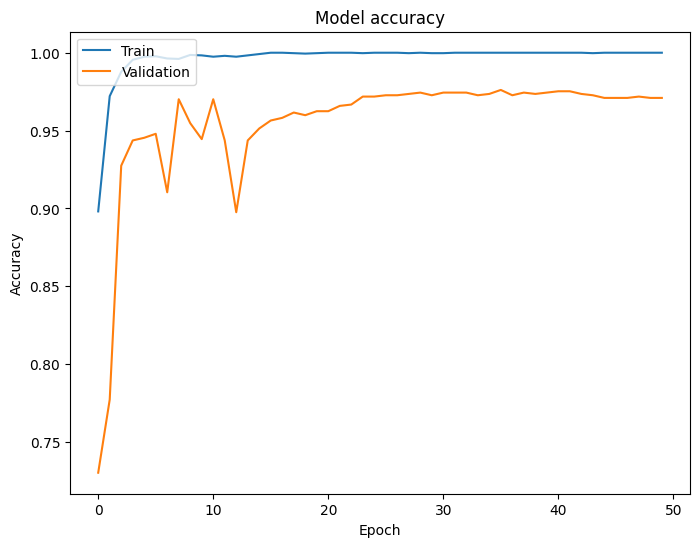

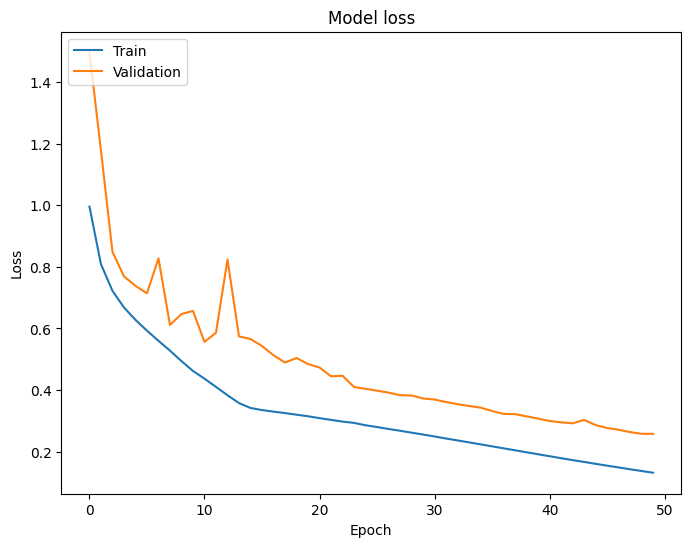

In [15]:
# Plotting training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Test Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, recall, precission = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

37/37 [==============================] - 1s 20ms/step - loss: 0.2412 - accuracy: 0.9752 - recall: 0.9859 - precision: 0.9802
Test Accuracy: 0.9752
1/1 [==============================] - 1s 626ms/step
Confusion Matrix


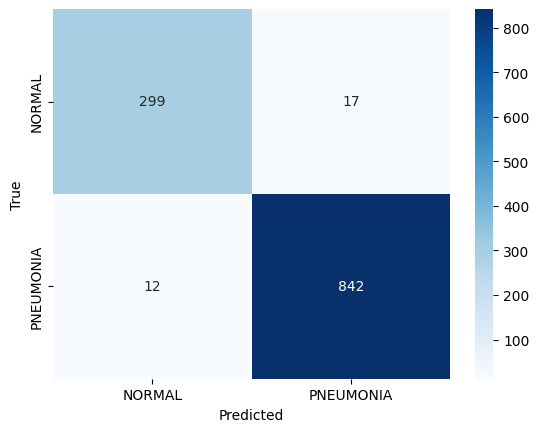

              precision    recall  f1-score   support

      NORMAL       0.96      0.95      0.95       316
   PNEUMONIA       0.98      0.99      0.98       854

    accuracy                           0.98      1170
   macro avg       0.97      0.97      0.97      1170
weighted avg       0.98      0.98      0.98      1170

Test F1 Score: 0.9831


In [17]:

# Predict the test dataset
y_pred = []
y_true = []

class_names = ['NORMAL', 'PNEUMONIA']  # Assuming 0 is 'NORMAL' and 1 is 'PNEUMONIA'

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(predictions)

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Convert probabilities to binary outcomes
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification report and F1 Score
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {f1:.4f}')

# Test with Another Datasets

In [ ]:
another_test_dir = root_folder + 'another_test_dir_path'

In [ ]:
test_another_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    another_test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    shuffle=False  # Don't shuffle the test data
)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, recall, precission = model.evaluate(test_another_datasets)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
test_dataset.reset()
# Predict the test dataset
y_pred = []
y_true = []

class_names = ['NORMAL', 'PNEUMONIA']  # Assuming 0 is 'NORMAL' and 1 is 'PNEUMONIA'

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(predictions)

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Convert probabilities to binary outcomes
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification report and F1 Score
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {f1:.4f}')

# Augmentasi

In [45]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def create_data_generators(train_dir, val_dir, test_dir, img_size=IMG_SIZE):
    # Data Augmentation for Training based on the paper
    train_datagen = ImageDataGenerator(
        rotation_range=20,        # Randomly rotate images by up to 20 degrees
        width_shift_range=0.2,    # Shift the image horizontally by 20%
        height_shift_range=0.2,   # Shift the image vertically by 20%
        shear_range=0.2,          # Shear intensity (similar to cropping)
        zoom_range=0.2,           # Random zoom by 20%
        horizontal_flip=True,     # Flip images horizontally
        vertical_flip=True,       # Flip images vertically
        fill_mode='nearest'       # Fill any empty pixels after augmentation
    )

    # Validation and Test data without augmentation
    val_datagen = ImageDataGenerator()  # No rescale
    test_datagen = ImageDataGenerator()  # No rescale

    # Prepare data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Don't shuffle for testing
    )

    return train_generator, validation_generator, test_generator


In [46]:
def create_model(learning_rate=0.00005, units=512):
    # Load the base MobileNetV2 model, excluding the top layers
    input = tf.keras.layers.Input(shape=(224, 224, 3))
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = True

    # Add custom layers on top of it
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First Dense layer with BatchNormalization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Second Dense layer with BatchNormalization and Dropout
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Output layer for binary classification
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

In [48]:
# Function to train the model
def train_model(model, train_generator, validation_generator, epochs=50):
    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit the model
    history = model.fit(
        train_generator,
        # steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        # validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs,
        callbacks=[reduce_lr, early_stopping]
    )

    return history

In [49]:
# Main function to orchestrate the process
def main(train_dir, val_dir, test_dir):
    # Create data generators
    train_generator, validation_generator, test_generator = create_data_generators(train_dir, val_dir, test_dir)

    # Create the model
    model = create_model()

    # Train the model
    history = train_model(model, train_generator, validation_generator)

    return model, history, test_generator

In [50]:
# Run the training process
model, history, test_generator = main(train_dir, val_dir, test_dir)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Epoch 1/50
110/110 [==============================] - 59s 383ms/step - loss: 1.0725 - accuracy: 0.8571 - precision_1: 0.8894 - recall_1: 0.9185 - val_loss: 1.5310 - val_accuracy: 0.7295 - val_precision_1: 0.7299 - val_recall_1: 0.9988 - lr: 5.0000e-05
Epoch 2/50
110/110 [==============================] - 42s 385ms/step - loss: 0.9044 - accuracy: 0.9351 - precision_1: 0.9482 - recall_1: 0.9637 - val_loss: 1.8764 - val_accuracy: 0.7295 - val_precision_1: 0.7295 - val_recall_1: 1.0000 - lr: 5.0000e-05
Epoch 3/50
110/110 [==============================] - 41s 376ms/step - loss: 0.8551 - accuracy: 0.9451 - precision_1: 0.9597 - recall_1: 0.9653 - val_loss: 1.6988 - val_accuracy: 0.7346 - val_precision_1: 0.7333 - val_recall_1: 1.0000 - lr: 5.0000e-05
Epoch 4/50
110/110 [==============================] - 42s 381ms/step - loss: 0.8076 - accuracy: 0.9556 - precision_1: 

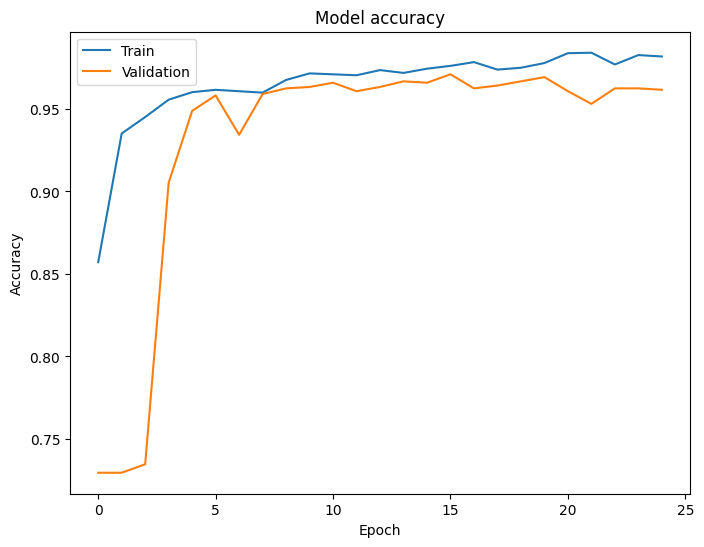

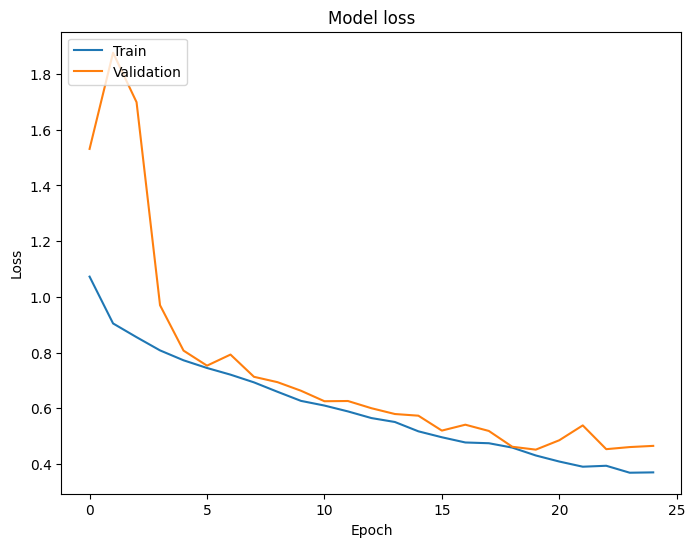

In [53]:
# Plotting training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Test Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

37/37 [==============================] - 6s 148ms/step - loss: 0.4527 - accuracy: 0.9718 - precision_1: 0.9904 - recall_1: 0.9707
Test Accuracy: 0.9718
37/37 [==============================] - 6s 142ms/step
Confusion Matrix


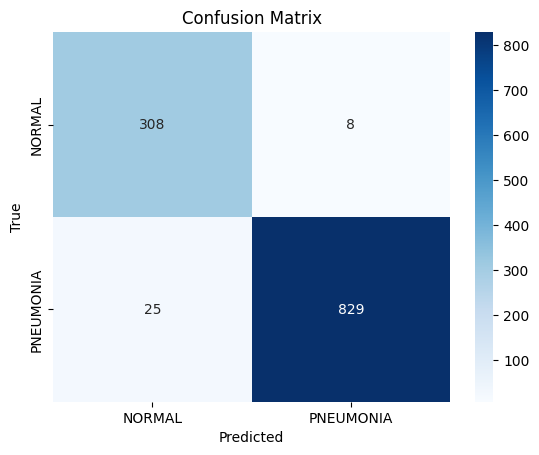

              precision    recall  f1-score   support

      NORMAL       0.92      0.97      0.95       316
   PNEUMONIA       0.99      0.97      0.98       854

    accuracy                           0.97      1170
   macro avg       0.96      0.97      0.96      1170
weighted avg       0.97      0.97      0.97      1170

Test F1 Score: 0.9805


In [52]:
# Make sure the generator is reset before making predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

# Get true labels
y_true = test_generator.classes

# Define class names
class_names = ['NORMAL', 'PNEUMONIA']  # Assuming 0 is 'NORMAL' and 1 is 'PNEUMONIA'

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report and F1 Score
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {f1:.4f}')

# Test with another datasets

In [ ]:
another_test_dir = root_folder + 'another_test_dir_path'

In [ ]:
test_another_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    another_test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    shuffle=False  # Don't shuffle the test data
)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy, recall, precission = model.evaluate(test_another_datasets)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
test_dataset.reset()
# Predict the test dataset
y_pred = []
y_true = []

class_names = ['NORMAL', 'PNEUMONIA']  # Assuming 0 is 'NORMAL' and 1 is 'PNEUMONIA'

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(predictions)

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Convert probabilities to binary outcomes
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification report and F1 Score
print(classification_report(y_true, y_pred, target_names=class_names))
f1 = f1_score(y_true, y_pred)
print(f'Test F1 Score: {f1:.4f}')

# Hyperparametertuning (outdated)

In [ ]:
def create_model(learning_rate, units):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Grid search parameters
learning_rates = [1e-3, 1e-4]
units_list = [256, 512]

# List to store results
results = []

# Grid search loop
for lr in learning_rates:
    for units in units_list:
        print(f"\nTraining with learning_rate={lr} and units={units}")

        # Clear session to reset the model state
        tf.keras.backend.clear_session()

        # Create model
        model = create_model(learning_rate=lr, units=units)

        # Prepare the data generators
        train_datagen = ImageDataGenerator(rescale=1./255)
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            batch_size=32,
            class_mode='binary'
        )

        val_datagen = ImageDataGenerator(rescale=1./255)
        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=(224, 224),
            batch_size=16,
            class_mode='binary'
        )

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[early_stopping]
        )

        # Evaluate the model
        val_loss, val_acc = model.evaluate(val_generator)
        print(f"Validation accuracy: {val_acc}")

        # Append results
        results.append({
            'learning_rate': lr,
            'units': units,
            'val_accuracy': val_acc
        })

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)

# Find the best parameters
best_params = df_results.loc[df_results['val_accuracy'].idxmax()]


Training with learning_rate=0.001 and units=256
Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 128s 712ms/step - accuracy: 0.8948 - loss: 0.2250 - val_accuracy: 0.6246 - val_loss: 2.1496
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 388ms/step - accuracy: 0.9675 - loss: 0.0884 - val_accuracy: 0.8387 - val_loss: 0.9117
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 382ms/step - accuracy: 0.9733 - loss: 0.0667 - val_accuracy: 0.7935 - val_loss: 1.4040
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 388ms/step - accuracy: 0.9771 - loss: 0.0648 - val_accuracy: 0.2986 - val_loss: 7.3448
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 382ms/step - accuracy: 0.9829 - loss: 0.0511 - val_accuracy: 0.2705 - val_loss: 12.0726
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.8400 - loss: 0.9331
Validation accuracy: 0.8387371897697449

Training with learning_rate=0.001 and units=512
Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 112s 613ms/step - accuracy: 0.9166 - loss: 0.2174 - val_accuracy:

In [ ]:
print("\nBest Parameters:")
print(best_params)


Best Parameters:
learning_rate      0.001000
units            512.000000
val_accuracy       0.930034
Name: 1, dtype: float64


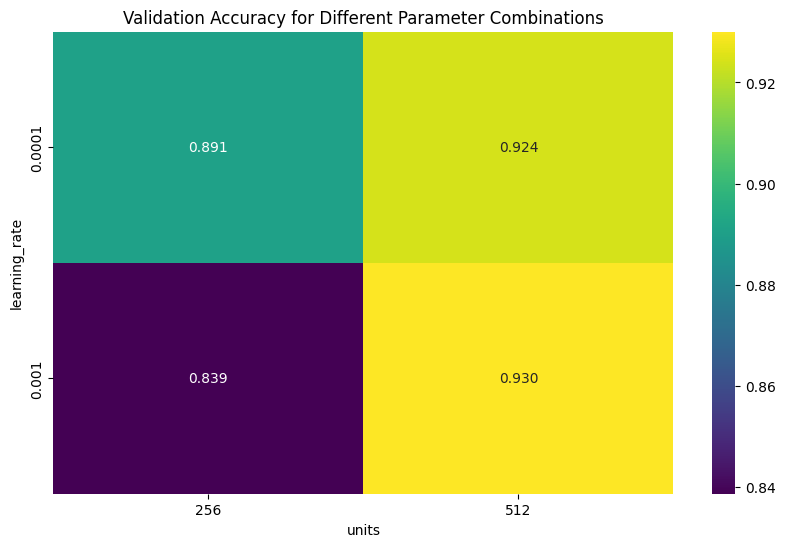

In [ ]:
# Create a pivot table
pivot_df = df_results.pivot_table(index='learning_rate', columns='units', values='val_accuracy')

# Plot the results
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='viridis')
plt.title('Validation Accuracy for Different Parameter Combinations')
plt.show()

# Time and Inference

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import time

In [19]:
def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [20]:
def create_datasets_for_time(train_dir, val_dir, test_dir, img_size=(260, 260)):
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=True,
        seed=123
    )

    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=False,
        seed=123
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=False  # Don't shuffle the test data
    )

    return train_dataset, val_dataset, test_dataset

In [23]:
# Function to create MobileNetV2 with custom input size and additional layers
def create_custom_mobilenetv2(input_size=(128, 128, 3), learning_rate=0.00005, num_classes=1):
    # # Load the base MobileNetV2 model with a new input size
    # base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)

    # # Add custom layers on top of it
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with BatchNormalization and Dropout
    # x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    # x = Dropout(0.4)(x)

    # # Second Dense layer with BatchNormalization and Dropout
    # x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    # x = Dropout(0.4)(x)

    # # Output layer for binary classification
    # predictions = Dense(1, activation='sigmoid')(x)

    # # Create the model
    # model = Model(inputs=base_model.input, outputs=predictions)

    # # Compile the model with an appropriate optimizer and loss function
    # model.compile(optimizer=Adam(learning_rate=learning_rate),
    #               loss='binary_crossentropy',
    #               metrics=['accuracy'])

    # return model

    # Load the base MobileNetV2 model, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)
    base_model.trainable = True

    # Add custom layers on top of it
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First Dense layer with BatchNormalization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Second Dense layer with BatchNormalization and Dropout
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.25)(x)

    # Output layer for binary classification
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze all layers in the base model for fine-tuning

    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(), Precision()])

    return model

# List of input sizes to loop over (dimen size)
input_sizes = [(128, 128, 3), (160, 160, 3), (192, 192, 3), (224, 224, 3)]

# Loop through each input size, create the model, and measure training time and accuracy
for size in input_sizes:
    print(f"\nCreating and training model with input size {size}...")

    # Create the model for the current input size
    model = create_custom_mobilenetv2(input_size=size, learning_rate=1e-3)

    # Start timer
    start_time = time.time()

    # Train the model (you would need to set up train_generator, val_generator, etc.)
    train_dataset, val_dataset, test_dataset = create_datasets_for_time(train_dir, val_dir, test_dir, img_size=(size[0], size[1]))
    history = model.fit(
        train_dataset,
        # steps_per_epoch=len(train_dataset),
        validation_data=val_dataset,
        # validation_steps=len(val_dataset),
        epochs=10  # Number of epochs for training
    )

    # End timer
    end_time = time.time()

    # Calculate total training time
    total_time = end_time - start_time

    # Get final validation accuracy from the history object
    final_val_accuracy = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

    print(f"Training complete for input size {size}")
    print(f"Total training time for input size {size}: {total_time:.2f} seconds")
    print(f"Final validation accuracy for input size {size}: {final_val_accuracy:.4f}\n")


Creating and training model with input size (128, 128, 3)...
9406464/9406464 [==============================] - 0s 0us/step
Found 3514 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.
Epoch 1/10
110/110 [==============================] - 24s 55ms/step - loss: 0.7504 - accuracy: 0.9294 - recall_1: 0.9622 - precision_1: 0.9423 - val_loss: 15.5574 - val_accuracy: 0.2722 - val_recall_1: 0.0023 - val_precision_1: 1.0000
Epoch 2/10
110/110 [==============================] - 5s 44ms/step - loss: 0.4145 - accuracy: 0.9525 - recall_1: 0.9793 - precision_1: 0.9566 - val_loss: 13.5682 - val_accuracy: 0.2756 - val_recall_1: 0.0070 - val_precision_1: 1.0000
Epoch 3/10
110/110 [==============================] - 5s 46ms/step - loss: 0.2342 - accuracy: 0.9710 - recall_1: 0.9860 - precision_1: 0.9746 - val_loss: 19.8387 - val_accuracy: 0.2713 - val_recall_1: 0.0012 - val_precision_1: 1.0000
Epoch 4/10
110/110 [=============================

# Hyperparameter Tuning

In [5]:
# Function to create a MobileNetV2-based model with dropout rate as a hyperparameter
def create_model_for_tuning(learning_rate, dropout_rate, input_shape=(224, 224, 3)):
    # Load the base MobileNetV2 model, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    # Add custom layers on top of it
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First Dense layer with BatchNormalization and Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)

    # Second Dense layer with BatchNormalization and Dropout
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for binary classification
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze all layers in the base model for fine-tuning

    # Compile the model with an appropriate optimizer and loss function
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(), Precision()])

    return model


In [6]:
# Hyperparameters to test
learning_rates = [1e-3, 1e-4, 1e-5]  # Learning rates to try
dropout_rates = [0.1, 0.2, 0.3]      # Dropout rates to try

# List to store results
results = []

# Grid search loop for hyperparameter tuning
for lr in learning_rates:
    for dropout in dropout_rates:
        print(f"\nTraining with learning_rate={lr} and dropout_rate={dropout}")

        # Clear session to reset the model state
        tf.keras.backend.clear_session()

        # Create model with current hyperparameters
        model = create_model_for_tuning(learning_rate=lr, dropout_rate=dropout)

        # Prepare the data generators (assuming you have directories train_dir and val_dir)
        train_datagen = ImageDataGenerator()
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(224, 224),
            class_mode='binary'
        )

        val_datagen = ImageDataGenerator()
        val_generator = val_datagen.flow_from_directory(
            val_dir,
            target_size=(224, 224),
            class_mode='binary'
        )

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Train the model
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate the model
        val_loss, val_acc, val_recall, val_precission = model.evaluate(val_generator)
        print(f"Validation accuracy: {val_acc:.4f}")

        # Append results to the list
        results.append({
            'learning_rate': lr,
            'dropout_rate': dropout,
            'val_accuracy': val_acc
        })

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)

# Print the DataFrame with all results
print("\nResults from hyperparameter tuning:")
print(df_results)

# Find and print the best hyperparameters based on validation accuracy
best_params = df_results.loc[df_results['val_accuracy'].idxmax()]
print("\nBest Hyperparameters:")
print(best_params)


Training with learning_rate=0.001 and dropout_rate=0.1


2024-10-10 13:10:10.255456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/10


2024-10-10 13:10:19.529952: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-10 13:10:19.535904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-10 13:10:19.627741: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-10 13:10:21.107857: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x799acc6cbea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 13:10:21.107892: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-10 13:10:21.113036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 13:10:21.208956: I ./tensorflow/compiler/jit/device_comp

110/110 [==============================] - 44s 206ms/step - loss: 0.6888 - accuracy: 0.9365 - recall: 0.9594 - precision: 0.9539 - val_loss: 16.5884 - val_accuracy: 0.2722 - val_recall: 0.0023 - val_precision: 1.0000
Epoch 2/10
110/110 [==============================] - 22s 196ms/step - loss: 0.3340 - accuracy: 0.9599 - recall: 0.9766 - precision: 0.9687 - val_loss: 12.6537 - val_accuracy: 0.2705 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
110/110 [==============================] - 21s 194ms/step - loss: 0.1985 - accuracy: 0.9696 - recall: 0.9801 - precision: 0.9782 - val_loss: 14.2592 - val_accuracy: 0.2705 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
110/110 [==============================] - 22s 197ms/step - loss: 0.1203 - accuracy: 0.9775 - recall: 0.9887 - precision: 0.9807 - val_loss: 16.0237 - val_accuracy: 0.2713 - val_recall: 0.0012 - val_precision: 1.0000
Epoch 5/10
37/37 [==============================] - 5s 142ms/step - loss: 12.6537 -

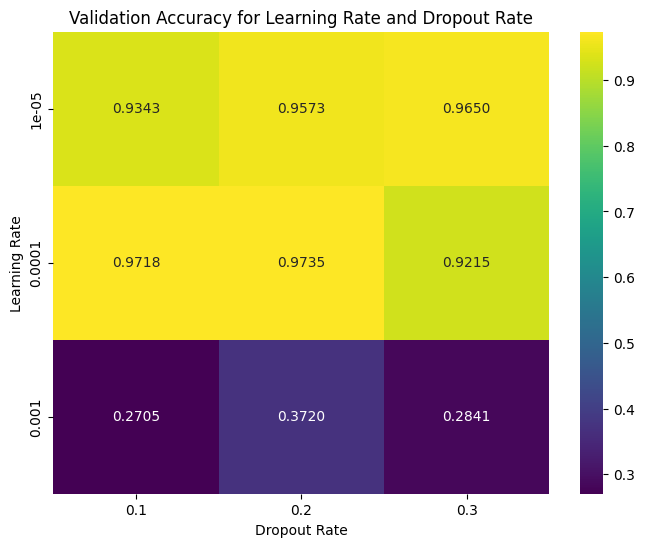

In [7]:
# Create a pivot table for heatmap (Learning Rate vs Dropout Rate)
pivot_df = df_results.pivot_table(index="learning_rate", columns="dropout_rate", values="val_accuracy")

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".4f")
plt.title("Validation Accuracy for Learning Rate and Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("Learning Rate")
plt.show()